In [1]:
import numpy as np
from tensorflow.contrib.rnn import BasicLSTMCell
import tensorflow as tf
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
batch_num = 1024
hidden_num = 1
elem_num = 1
max_sequence_len = 100
iteration = 400000

In [3]:
tf.reset_default_graph()

In [4]:
Y = tf.placeholder(tf.float32, shape=[None,1])
keep = tf.placeholder(tf.float32, shape=[])
data = tf.placeholder(shape=[batch_num, max_sequence_len,elem_num],dtype=tf.float32)
#####
cell = BasicLSTMCell(hidden_num)
cell = tf.contrib.rnn.DropoutWrapper(cell=cell,variational_recurrent=True,state_keep_prob=keep,input_size=1,dtype=tf.float32)
initial_state = cell.zero_state(batch_num, dtype=tf.float32)
value, states = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32,initial_state=initial_state)
#####
t_value = tf.transpose(value, [1, 0, 2])
last = tf.gather(t_value, int(t_value.get_shape()[0]) - 1)
Y_p_2 = tf.layers.dense(inputs=last,units=1)
cls_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=Y_p_2))
learning_rate = tf.placeholder(shape=[],dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cls_loss)
#####
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [5]:
loss_array = np.zeros(iteration)
step_num = max_sequence_len-1
lr = 0.1
hardness = 95
k_p = 0.8
for i in range(iteration):
        random_sequences = np.random.binomial(n=1,p=0.5,size=[batch_num,max_sequence_len,elem_num])
        random_sequences[:,0:step_num,:] *= 0
        sums = np.sum(random_sequences, axis=1)
        labels = np.mod(sums, 2)
        (loss_val, _) = sess.run([cls_loss,optimizer], {data: random_sequences,Y:labels,keep:k_p,learning_rate:lr})
        loss_array[i] = loss_val
        if ((i+1) % 1000 ) is 0:
            print('iter %d:' % (i + 1), loss_val)
        if loss_val < 0.1:
            step_num -= 1
            lr = 0.9 * lr
            print("---------------------------Step num:",max_sequence_len-step_num )
        if step_num < hardness:
            break

---------------------------Step num: 2
---------------------------Step num: 3
---------------------------Step num: 4
---------------------------Step num: 5
---------------------------Step num: 6


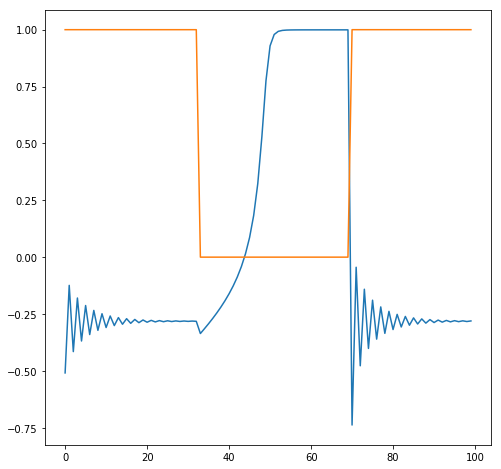

In [6]:
random_sequences = np.random.binomial(n=1,p=1,size=[batch_num,max_sequence_len,elem_num])
t_r = np.ones(([batch_num,max_sequence_len,elem_num]))
t_r[:,33:70,:] = 0
st = sess.run(value, {data: t_r,keep:1})
plt.figure(figsize=(8,8))
plt.plot(st[0,:,:].reshape([-1,1]))
plt.plot(t_r[0,:,:].reshape([-1,1]))
plt.show()